# Notebook setup

In [ ]:
#!pip install pydicom

In [ ]:
#! pip install -q kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download shashanks1202/skin-cancer-dataset

In [ ]:
!unzip skin-cancer-dataset.zip

# Demo 1: Image manipulation in Python

## Load data

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pydicom
import scipy.ndimage as ndi
from PIL import Image
from skimage import io
from sklearn import preprocessing
import tensorflow as tf
import os

In [ ]:
ben_dir = 'train_cancer/benign'
mal_dir = 'train_cancer/malignant'

In [ ]:
ben_files = os.listdir(ben_dir)
mal_files = os.listdir(mal_dir)

## Plot sample images

In [ ]:
# Function to load and display sample images
def display_sample_images(ben_path, mal_path):
    # Load images
    benign = io.imread(ben_path)
    malignant = io.imread(mal_path)

    # Display images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(benign, cmap='gray')
    ax1.set_title('Benign')
    ax2.imshow(malignant, cmap='gray')
    ax2.set_title('Malignant')
    plt.show()

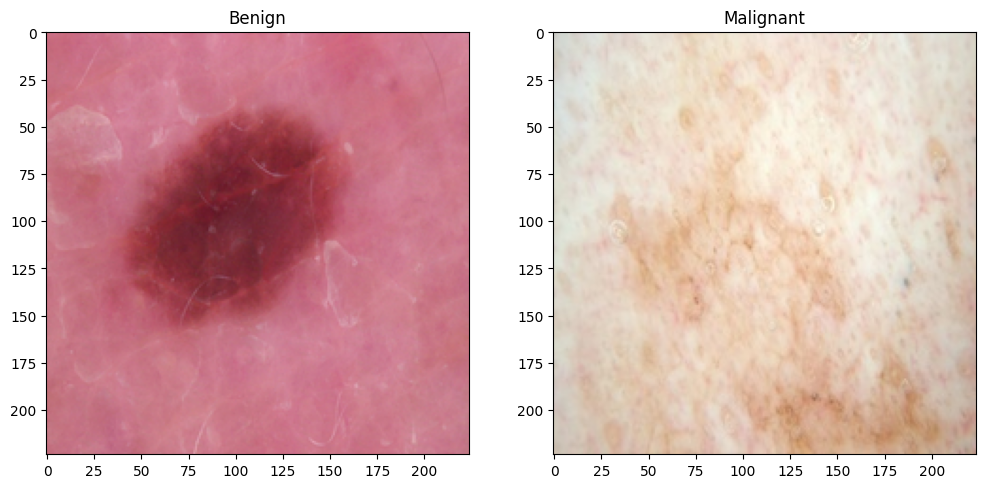

In [ ]:
# Display sample images
sample_ben = os.path.join(ben_dir, ben_files[1])
sample_mal = os.path.join(mal_dir, mal_files[0])
display_sample_images(sample_ben, sample_mal)

## Compare image histograms

In [ ]:
# Compare image histograms
def compare_image_histograms(ben_path, mal_path):
    # Load images
    benign = io.imread(ben_path)
    malignant = io.imread(mal_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(benign.ravel(), bins=256, range=(0, 255))
    ax1.set_title('Benign Image Histogram')
    ax2.hist(malignant.ravel(), bins=256, range=(0, 255))
    ax2.set_title('Malignant Image Histogram')
    plt.show()

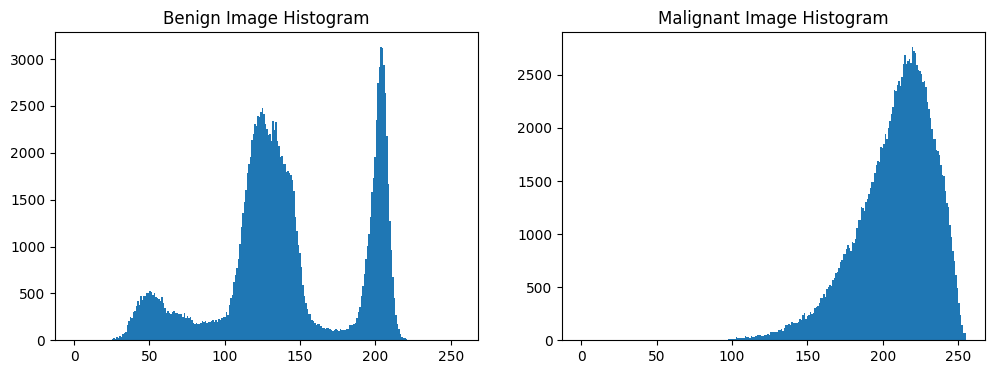

In [ ]:
compare_image_histograms(sample_ben, sample_mal)

## Thresholds and masks

In [ ]:
img = np.asarray(Image.open(sample_ben).convert('L'))

In [ ]:
img.shape

(224, 224)

In [ ]:
print('Data type:', img.dtype)
print('Min. value:', img.min())
print('Max value:', img.max())

Data type: uint8
Min. value: 48
Max value: 183


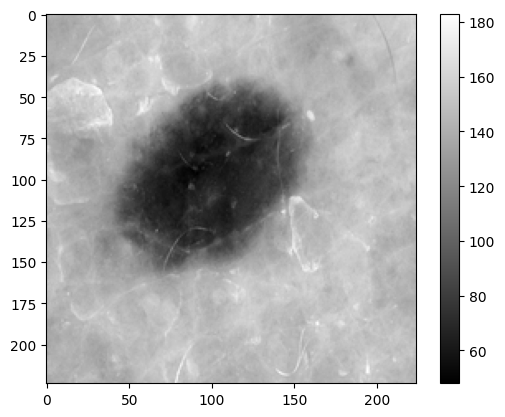

In [ ]:
plt.imshow(img, cmap="gray") # play with vmax, vmin, cmap
plt.colorbar()

In [ ]:
hist = ndi.histogram(img, min=46, max=201, bins=155)

In [ ]:
cdf = hist.cumsum() / hist.sum()

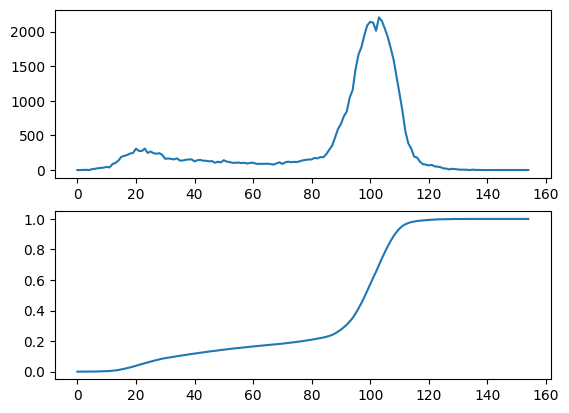

In [ ]:
# Plot the histogram and CDF
fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].plot(hist, label='Histogram')
axes[1].plot(cdf, label='CDF')
plt.show()

In [ ]:
mask_bg = img < 80
mask_fg = img > 80

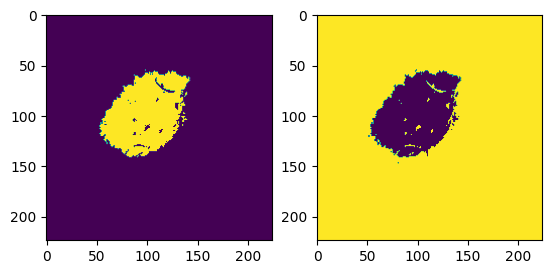

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(mask_bg)
axes[1].imshow(mask_fg)

In [ ]:
img_bg = np.where(mask_bg, img, 1)

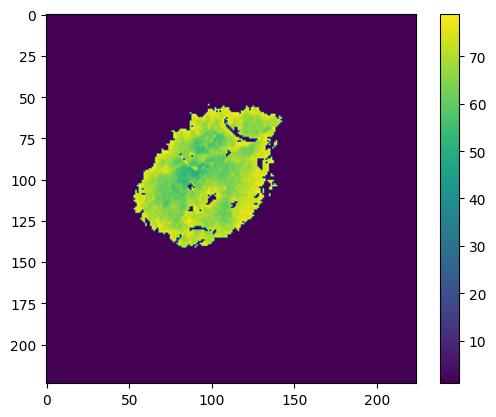

In [ ]:
plt.imshow(img_bg)
plt.colorbar()

In [ ]:
print('Data type:', img_bg.dtype)
print('Min. value:', img_bg.min())
print('Max value:', img_bg.max())

Data type: uint8
Min. value: 1
Max value: 79


## Filters and smoothing

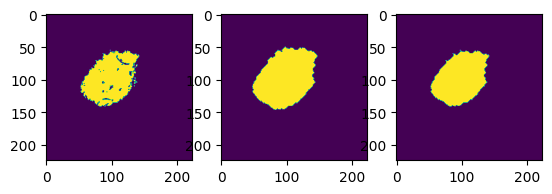

In [ ]:
mask_dilate=ndi.binary_dilation(mask_bg, iterations=5)
mask_closed=ndi.binary_closing(mask_bg, iterations=5)

fig, axs = plt.subplots(1,3)
axs[0].imshow(mask_bg)
axs[1].imshow(mask_dilate)
axs[2].imshow(mask_closed)
plt.show()

In [ ]:
im_smooth = ndi.gaussian_filter(img_bg, sigma=3)

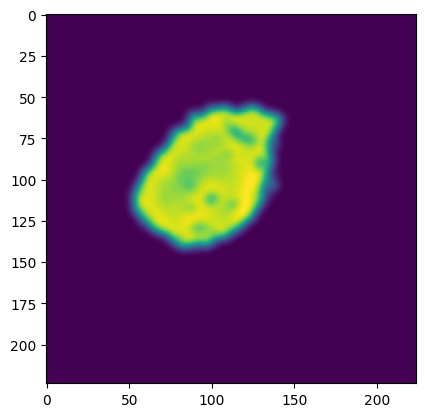

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im_smooth)
plt.show()

## Measure region of interest

In [ ]:
labels, nlabels = ndi.label(mask_closed)
print('Num. Labels:', nlabels)

Num. Labels: 3


In [ ]:
ndi.sum(1, labels, index=2) # multiply this by pixel size

5276

# DEMO 2: Predict whether skin lesion is benign or malignant

In [ ]:
#import libraries
from tensorflow.keras.applications.xception import decode_predictions

## Designate test and train datasets

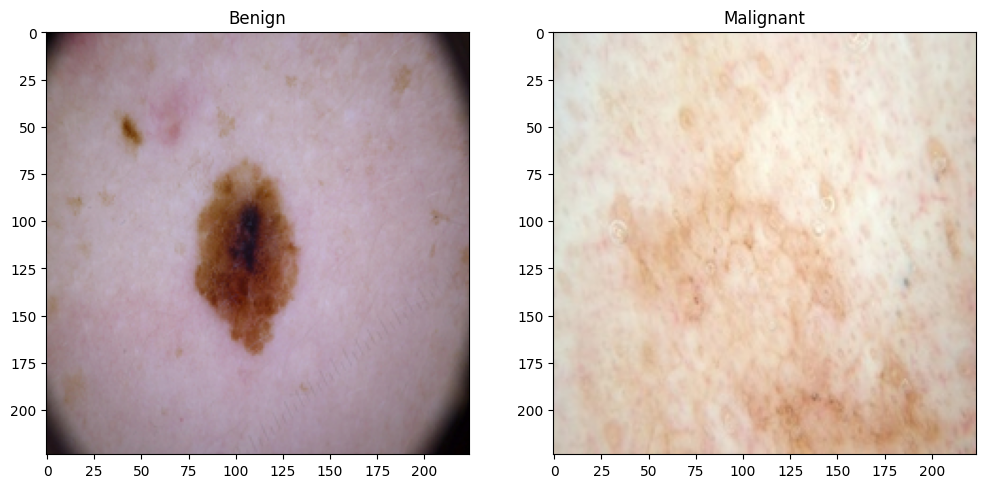

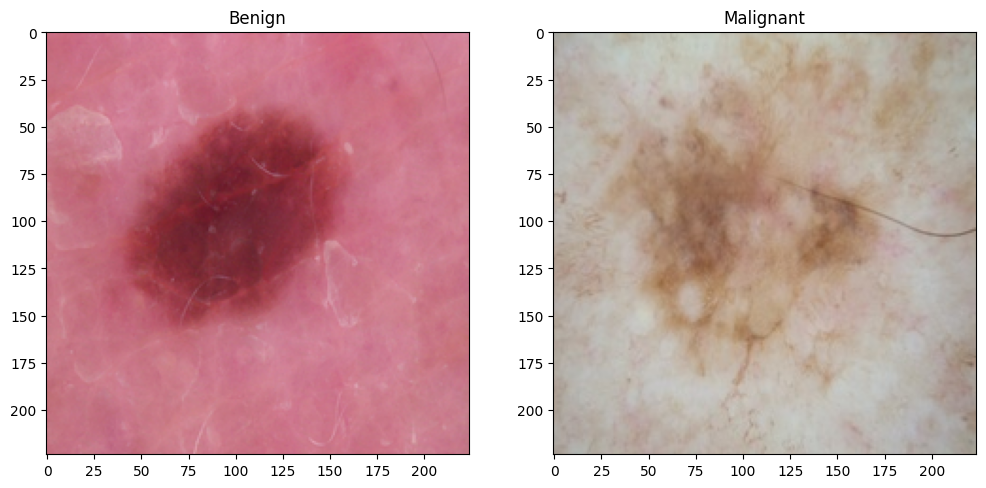

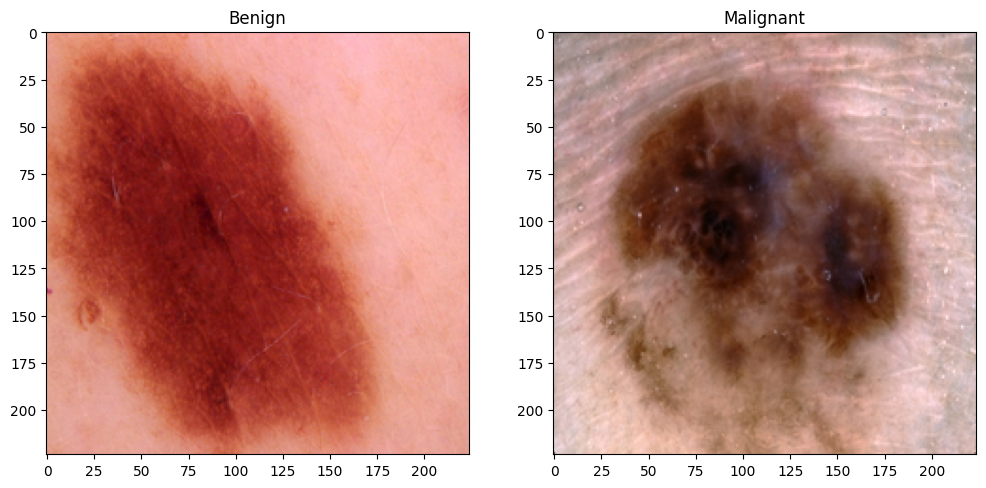

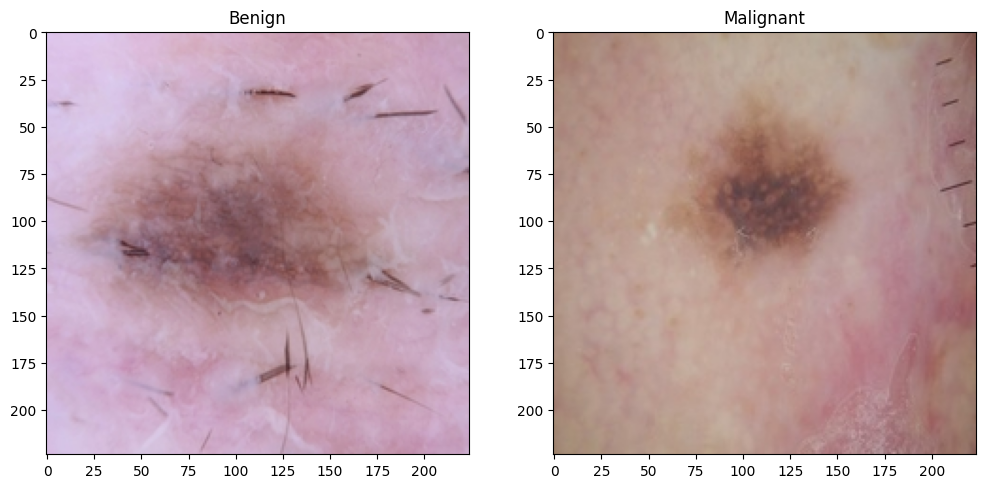

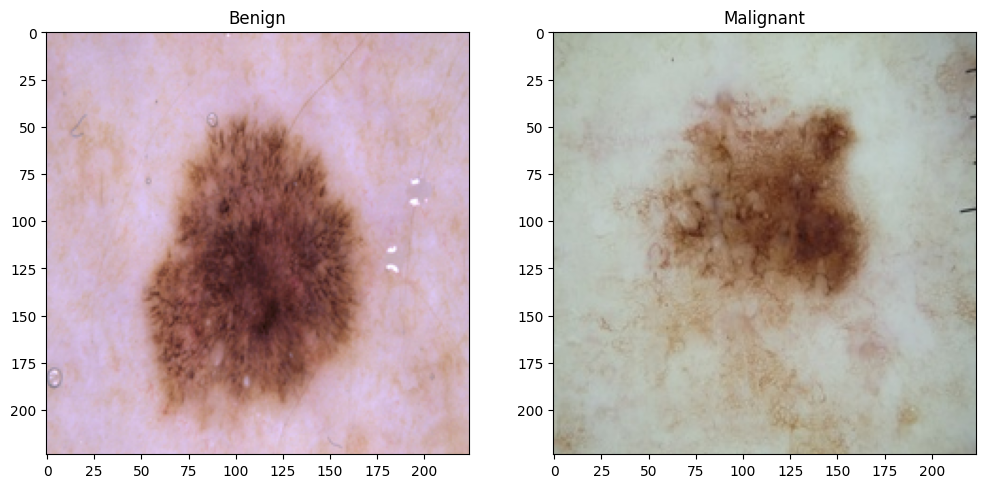

In [ ]:
for i in range(5):
  display_sample_images(os.path.join(ben_dir, ben_files[i]), os.path.join(mal_dir, mal_files[i]))

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

data_dir = 'train_cancer'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

for split_dir in [train_dir, val_dir, test_dir]:
    for category in ['benign', 'malignant']:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

def split_data(data_dir, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.1, 0.1)):
    for category in ['benign', 'malignant']:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)

        train_imgs, test_imgs = train_test_split(images, test_size=split_ratio[2], random_state=42)
        train_imgs, val_imgs = train_test_split(train_imgs, test_size=split_ratio[1] / (split_ratio[0] + split_ratio[1]), random_state=42)

        for img in train_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))

        for img in val_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

        for img in test_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

split_data(data_dir, train_dir, val_dir, test_dir)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 216 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


## Load pre-trained model or set up new model

In [ ]:
#load pre trained Xception model
model=tf.keras.applications.xception.Xception(weights='imagenet',include_top=True)
#Summary of Xception Model
model.summary

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<bound method Model.summary of <Functional name=xception, built=True>>

In [ ]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(448, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(448, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 222, 222, 224)       │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 224)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 109, 109, 448)       │         903,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 448)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 52, 52, 448)         │       1,806,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,716,672 (10.36 MB)

 Trainable params: 2,716,672 (10.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 222, 222, 224)       │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 224)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 109, 109, 448)       │         903,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 448)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 52, 52, 448)         │       1,806,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1211392)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      77,529,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,246,474 (306.12 MB)

 Trainable params: 80,246,474 (306.12 MB)

 Non-trainable params: 0 (0.00 B)

## Train model on our dataset

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=10,
                    validation_data=(val_generator))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 471s 66s/step - accuracy: 0.7495 - loss: 6.6760 - val_accuracy: 0.8889 - val_loss: 0.9982
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 463s 68s/step - accuracy: 0.8674 - loss: 0.8257 - val_accuracy: 0.8889 - val_loss: 0.3573
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 505s 66s/step - accuracy: 0.8757 - loss: 0.3859 - val_accuracy: 0.8889 - val_loss: 0.3875
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 468s 67s/step - accuracy: 0.8611 - loss: 0.5195 - val_accuracy: 0.8889 - val_loss: 0.3692
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 501s 66s/step - accuracy: 0.9118 - loss: 0.2584 - val_accuracy: 0.8889 - val_loss: 0.2091
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 461s 66s/step - accuracy: 0.9017 - loss: 0.4088 - val_accuracy: 0.8889 - val_loss: 0.3386
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 510s 65s/step - accuracy: 0.8769 - loss: 0.3833 - val_accuracy: 0.8889 - val_loss: 0.2691
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 501s 67s/step - accuracy: 0.9031 - loss: 0.2324 - val_accuracy: 0.9259 - val_loss:

## Test model performance

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 27 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.8889 - loss: 0.4294
Test Accuracy: 88.89%


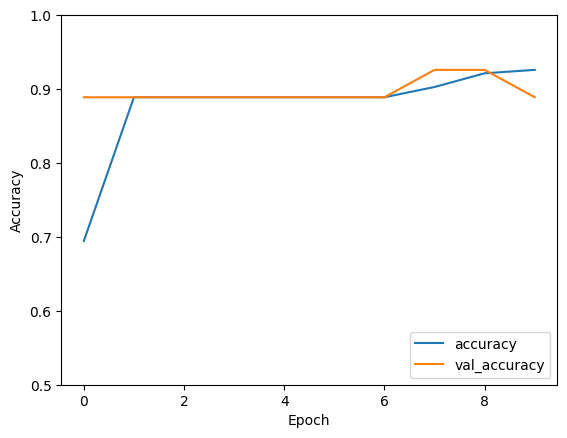

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')